In [17]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [18]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [19]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [20]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [21]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

C:\Users\jrams\AppData\Local\Temp\ipykernel_27804\4196587217.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [22]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [23]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.measurement

In [24]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [25]:
# Find the most recent date in the data set.
query = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date
query
most_recent = dt.datetime.strptime(query, '%Y-%m-%d')
most_recent

datetime.datetime(2017, 8, 23, 0, 0)

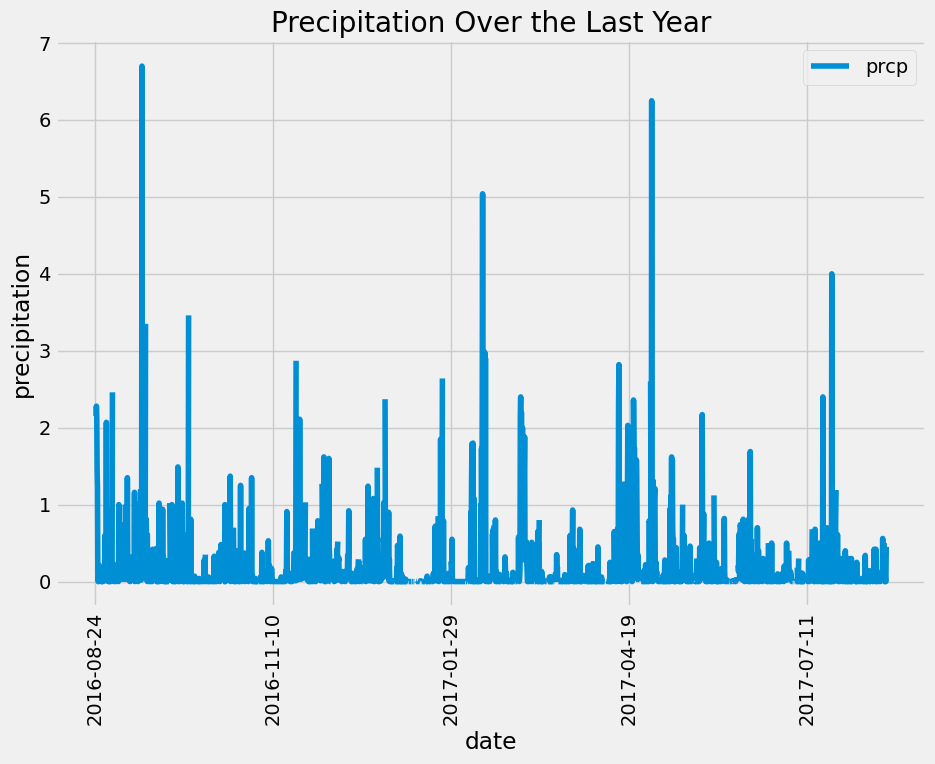

In [26]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_from_last = most_recent.replace(year=most_recent.year-1)


# Perform a query to retrieve the data and precipitation scores
data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_from_last).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation = pd.DataFrame(data, columns=['date', 'prcp'])

# Sort the dataframe by date
precipitation = precipitation.set_index('date').sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
precipitation.plot(figsize=(10, 7))
plt.title('Precipitation Over the Last Year')
plt.xlabel('date')
plt.xticks(rotation=90)
plt.ylabel('precipitation')
plt.show()


In [27]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary = precipitation.describe()
print(summary)

              prcp
count  2015.000000
mean      0.176462
std       0.460288
min       0.000000
25%       0.000000
50%       0.020000
75%       0.130000
max       6.700000


# Exploratory Station Analysis

In [28]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
total_stations


19550

In [29]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.id)).group_by(Measurement.station).order_by(func.count(Measurement.id).desc())
pd.Series(active_stations)

0    (USC00519281, 2772)
1    (USC00519397, 2724)
2    (USC00513117, 2709)
3    (USC00519523, 2669)
4    (USC00516128, 2612)
5    (USC00514830, 2202)
6    (USC00511918, 1979)
7    (USC00517948, 1372)
8     (USC00518838, 511)
dtype: object

In [30]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations.first().station

lowest_temp = session.query(Measurement.tobs).filter(Measurement.station==most_active_station).order_by(Measurement.tobs.asc()).first()
lowest_temp

highest_temp = session.query(Measurement.tobs).filter(Measurement.station==most_active_station).order_by(Measurement.tobs.desc()).first()
highest_temp

average_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station==most_active_station).group_by(Measurement.station).all()[0]
average_temp

print(lowest_temp, highest_temp, average_temp)

(54.0,) (85.0,) (71.66378066378067,)


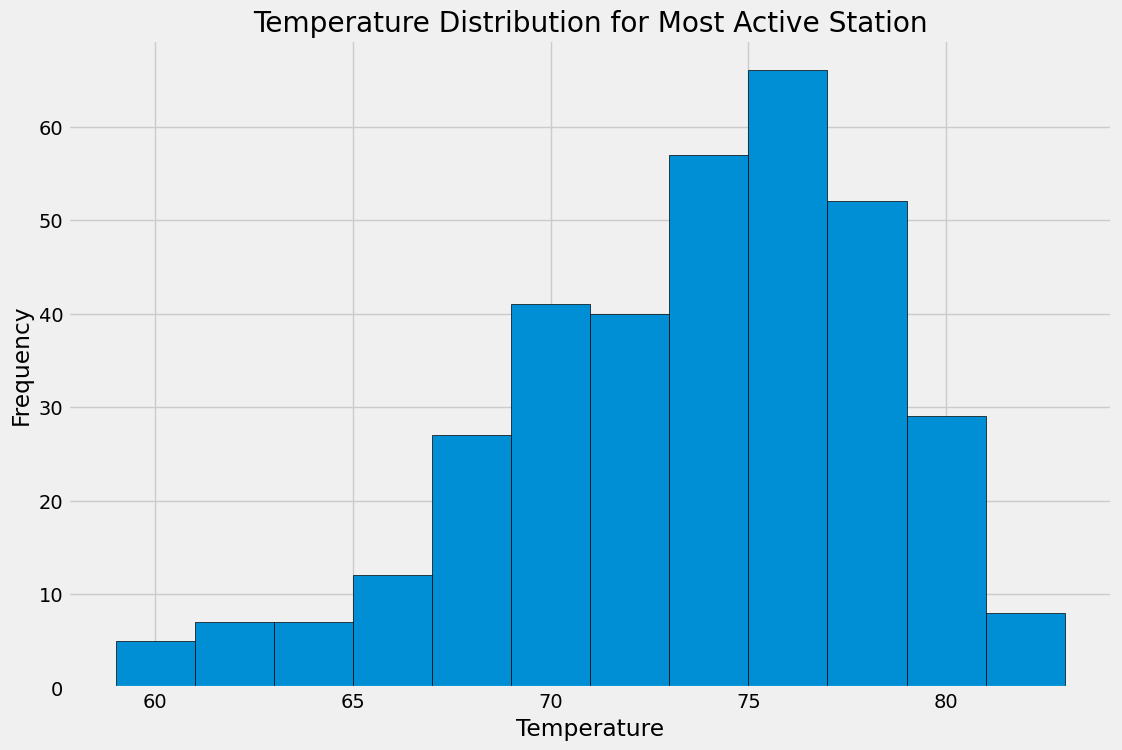

In [31]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station_data = session.query(Measurement.tobs, func.count(Measurement.id)).filter(Measurement.station==most_active_station).group_by(Measurement.tobs).filter(Measurement.date >= one_year_from_last).all()
station_plot = pd.DataFrame(most_active_station_data, columns=['Tempurature', 'Frequency'])

plt.figure(figsize=(12, 8))
plt.hist(station_plot['Tempurature'], weights=station_plot['Frequency'], bins=12, edgecolor='black')
plt.title('Temperature Distribution for Most Active Station')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()



# Close Session

In [32]:
# Close Session
session.close()